# Let's check out MNIST

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"font.family" : ["Serif"]})

Many of the algorithms used in statistics and machine learning are not coordinate independent. For this reason, pre-processing is often required before fitting a model. Luckily, mnist is already in pristine condition, so no pre-processing is required. Moreover, [the official binary files](http://yann.lecun.com/exdb/mnist/) are really easy to parse, so I will just use the tensorflow mnist downloader.



In [3]:
# tensorflow mnist downloader
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


the python object `mnist` contains a training set with 55000 images, a validation set with 5000 images and a test set with 10000 images.

In [4]:
print("training feature size :", mnist.train.images.shape)
print("validation feature size :", mnist.validation.images.shape)
print("test feature size :", mnist.test.images.shape)

training feature size : (55000, 784)
validation feature size : (5000, 784)
test feature size : (10000, 784)


label : [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


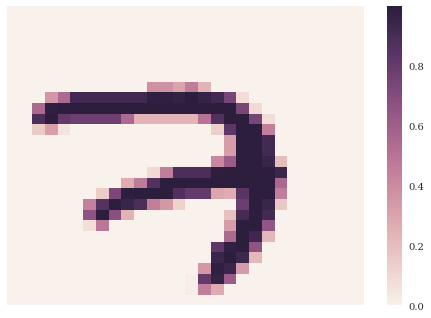

In [5]:
sns.heatmap(mnist.train.images[0].reshape(28,28)
            ,xticklabels=False
            ,yticklabels=False);
print("label :", mnist.train.labels[0])

We are going to use some Discriminative models to try and predict the label from the image. I wrote a [blog post](http://danielbarter.github.io/posts/statistics/2016-06-15-the-discriminative-approach-to-classification-for-mnist.html) about the math behind this.

### Model 1 : Linear function > softmax. MLE. 2 hours.

In [6]:
linear_softmax_mle = tf.Graph()

In [7]:
with linear_softmax_mle.as_default():
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.random_normal([784, 10],stddev=0.1))
    b = tf.Variable(tf.random_normal([10],stddev=0.1))
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    y_ = tf.placeholder(tf.float32, [None, 10])
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    train = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

The `mnist.train` object has a `next_batch` method whose source can be found [here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py). It lets us sample without replacement from the feature,label pairs. Perfect for stochastic gradient descent. I don't want my laptop to melt!

In [8]:
def train_linear_softmax_mle():
    with tf.Session(graph = linear_softmax_mle) as sess:
        cross_entropy_list = []
        sess.run(tf.global_variables_initializer())
        for step in range(1000):
            x_data,y_data = mnist.train.next_batch(100)
            _,l = sess.run([train,cross_entropy]
                           ,feed_dict = {x : x_data, y_ : y_data}
                          )
            cross_entropy_list.append(l)
        validation_accuracy = sess.run(accuracy
                                       ,feed_dict = {x : mnist.validation.images
                                                     , y_ : mnist.validation.labels
                                                    }
                             )
        
        mle = sess.run(W)
        print("validation accuracy = %f" % validation_accuracy)
        fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,6))
        sns.heatmap(mle,xticklabels=False,yticklabels=False,ax=ax1)
        ax1.set_title("heatmap for W")
        ax2.plot(np.arange(0,1000),np.array(cross_entropy_list))
        ax2.set_title("cross entropy")
        plt.show()

validation accuracy = 0.923400


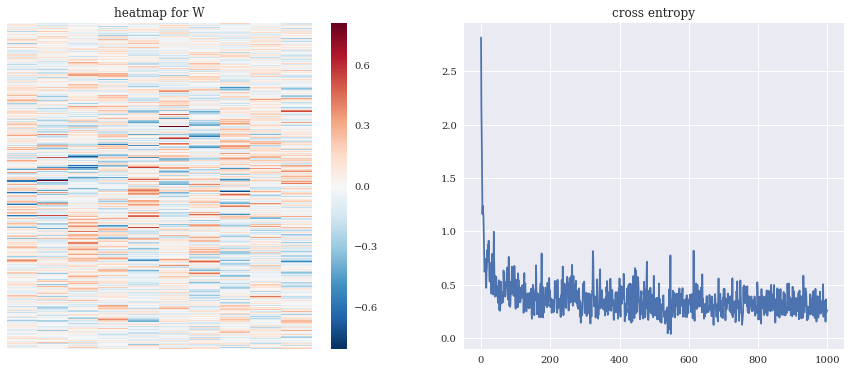

In [9]:
train_linear_softmax_mle()

### Model 2 : Linear Function > RELU > Linear Function > softmax. MLE. 1 hour.

In [10]:
nonlinear_softmax_mle = tf.Graph()

In [11]:
with nonlinear_softmax_mle.as_default():
    x = tf.placeholder(tf.float32, [None, 784])
    W1 = tf.Variable(tf.random_normal([784, 100],stddev=0.1))
    b1 = tf.Variable(tf.random_normal([100]))
    mid = tf.nn.relu(tf.matmul(x,W1) + b1)
    W2 = tf.Variable(tf.random_normal([100,10],stddev=0.1))
    b2 = tf.Variable(tf.random_normal([10],stddev=0.1))
    y = tf.nn.softmax(tf.matmul(mid, W2) + b2)
    y_ = tf.placeholder(tf.float32, [None, 10])
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    train = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
def train_nonlinear_softmax_mle():
    with tf.Session(graph = nonlinear_softmax_mle) as sess:
        cross_entropy_list = []
        sess.run(tf.global_variables_initializer())
        for step in range(1000):
            x_data,y_data = mnist.train.next_batch(100)
            _,l = sess.run([train,cross_entropy]
                           ,feed_dict = {x : x_data, y_ : y_data}
                          )
            cross_entropy_list.append(l)

        validation_accuracy = sess.run(accuracy
                                       ,feed_dict = {x : mnist.validation.images
                                                     , y_ : mnist.validation.labels
                                                    }
                             )
        mle_1 = sess.run(W1)
        mle_2 = sess.run(W2)
        print("validation accuracy = %f" % validation_accuracy)
        fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,6))
        sns.heatmap(mle_2,xticklabels=False,yticklabels=False,ax=ax1)
        ax2.plot(np.arange(0,1000),np.array(cross_entropy_list))
        ax2.set_title("cross entropy")
        ax1.set_title("heatmap for W2")

validation accuracy = 0.966000


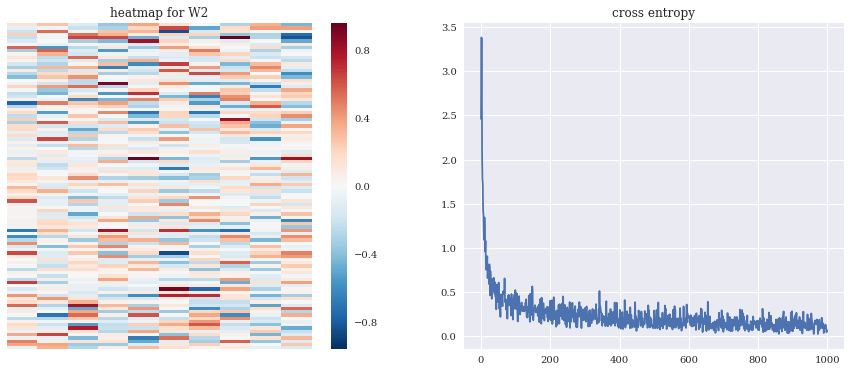

In [13]:
train_nonlinear_softmax_mle()